In [1]:
#%% Import libraries
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas

In [2]:
## Deterministic solution
def sdd(x, D, m, j):
    return j / np.sqrt(D * m) * np.exp(-x / np.sqrt(D / m))

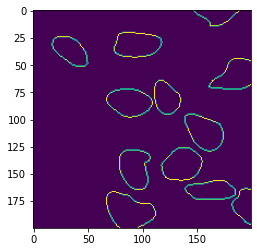

In [3]:
from skimage import io
import matplotlib.pyplot as plt

# read the image stack
img = io.imread('Field_Movement.tif')
image = io.imread('Field_Source.tif')
rec = io.imread('Field_Receptors.tif')
blind = io.imread('Field_ROI (2).tif')

# show the image
plt.imshow(rec)

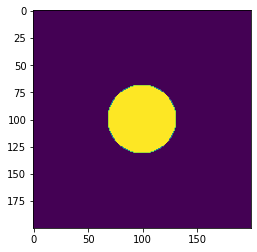

In [4]:
plt.imshow(blind)

In [5]:
receptorClass = np.array(rec)
rows, cols = np.where(receptorClass == 255) #convert to 2d array
recepCoords = np.empty((0,2))
i,j = 0,0
while i < len(rows):
    recepCoords = np.append(recepCoords, np.array([[cols[i], rows[j]]]), axis = 0)
    i += 1
    j += 1

recepCoords
#ok.

array([[147.,   0.],
       [189.,   0.],
       [148.,   1.],
       ...,
       [ 98., 198.],
       [ 79., 199.],
       [ 96., 199.]])

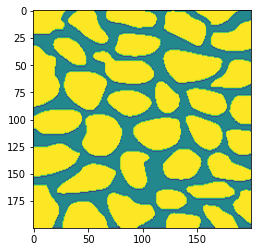

In [6]:
plt.imshow(img)

In [7]:
boundaryClass = np.array(img)

#boundaryClass = np.transpose(boundaryClass)
boundaryClass

#if a particle is at [y][x] then it will have the said boundary conditions
#eg [1][0] will have the boundary condition 8 (cannot move up)


array([[32, 32, 32, ...,  8,  8,  7],
       [32, 32, 32, ..., 16, 16, 15],
       [32, 32, 32, ..., 16, 16, 15],
       ...,
       [32, 32, 32, ..., 16, 16, 15],
       [32, 32, 32, ..., 16, 16, 15],
       [32, 32, 32, ..., 12, 12, 11]], dtype=uint8)

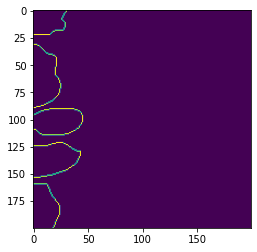

In [8]:
plt.imshow(image)

In [9]:
killClass = np.array(blind)
rows, cols = np.where(killClass == 255) #convert to 2d array
killCoords = np.empty((0,2))
i,j = 0,0
while i < len(rows):
    killCoords = np.append(killCoords, np.array([[cols[i], rows[j]]]), axis = 0)
    i += 1
    j += 1

killCoords
#ok.

array([[ 92.,  69.],
       [ 93.,  69.],
       [ 94.,  69.],
       ...,
       [105., 130.],
       [106., 130.],
       [107., 130.]])

In [10]:
def pixelClass(ii):
    x, y = int(ii[0]), int(ii[1]) #don't transpose
    return boundaryClass[y][x]  #1 indexed

    #ok.


In [11]:
#x = []
#for i in sourceCoords:
 #   x.append(pixelClass(i))
#x

In [12]:
lookUpTable = pandas.read_csv('lookUpTable.csv')
lookUpTable = lookUpTable.values #removes the headers

#ok.


In [13]:
sourceClass = np.array(image)
rows, cols = np.where(sourceClass == 255) #convert to 2d array
sourceCoords = np.empty((0,2))
i,j = 0,0
while i < len(rows):
    sourceCoords = np.append(sourceCoords, np.array([[cols[i], rows[j]]]), axis = 0)
    i += 1
    j += 1
numSource = len(sourceCoords)


In [14]:
dimImage = image.shape
Lx = dimImage[1] 
Ly = dimImage[0] 
Lx

200

In [15]:
recepCoords

array([[147.,   0.],
       [189.,   0.],
       [148.,   1.],
       ...,
       [ 98., 198.],
       [ 79., 199.],
       [ 96., 199.]])

In [16]:
#%% Define Parameters
    
## Simulation parameters
#Lx      = 500                   # length of system (500 um)
dx      = 1.00                  # camera pixel size (1 um)
nx      = round(Lx/dx)          # number of positions (pixels)
xx      = np.arange(nx+1)*dx    # x bin edges

#Ly      = 500                   # length of system (500 um)
dy      = 1.00                  # camera pixel size (1 um)
ny      = round(Ly/dy)          # number of positions (pixels)
yy      = np.arange(ny+1)*dy    # y bin edge

In [17]:
## Dynamic parameters
D               = 10          # diffusion constant
Decay_Time      = 18         # decay time in minutes
mu              = (Decay_Time*60) ** (-1)  # disassociation rate
J               = 0.002            # Insertion rate

## Probabilities and derived parameters
dt      = dx**2/(D*2*2)         # assumes dy = dx
p_J     = J * dt  #number of source position
p_mu    = mu * dt
k_on = 0.6
k_off = 0.5
## Time Variables

Ttotal  = 2*60*60               # time in seconds
nt      = round(Ttotal/dt)+1
dtsave  = 2*60              # save every "10 mins"
dsave   = round(dtsave/dt)      
nsave   = round(Ttotal/dtsave)+1

In [18]:
k_on*dt*(recepCoords.shape[0])

15.42

In [19]:
k_off*dt*(recepCoords.shape[0])

12.850000000000001

In [ ]:
start = time.time()
distribFree = np.empty((0,2))
distribBound = np.empty((0,2))
density = np.zeros((nx,nsave))
birthRate = J*numSource*dt
p_bind = k_on*dt*(recepCoords.shape[0])
p_unbind = k_off*dt*(recepCoords.shape[0])
moveDict = {'l':[-1,0],'r':[1,0], 'u':[0,-1],'d':[0,1]}
count = 0
cmax = 0 #find cmax
bomb, checkFlag = False, False #start adding coordinates the first time the difference in part num is within 0.03 (or 0.05)
#checks if bomb has happened
prev,current = 0,0 #part num per interval
particleVector = [] #to plot number of particles in roi
totalVector = [] #to check if system is at ss
for count in range (1,nt):
    ##image source code##
    instBirth = np.random.poisson(birthRate) #random select number born at current time, replaces add
    for ii in range(1, instBirth +1):
        instSource = np.random.choice(numSource) #random select source position, replaces new
        new = [sourceCoords[instSource]]
        distribFree = np.append(distribFree, np.array(new), axis=0)#change shape of sourcePos[instSource]
    pixelClasses = np.empty(0, dtype=int)
    ##obstacle code##
    x = []
    for ii in distribFree: 
        x.append(pixelClass(ii)) #we have some 32's but will throw them away    
    for jj in range(1,17):
        x = np.array(x)
        indexPart = np.where(x == jj)[0] #returns the index in distrib where the particles have said class
        numInClass = len(indexPart)
        numFree = lookUpTable[jj-1][-1] #adjusts the index to the correct one
        randMove = np.random.uniform(low = 1, high = numFree+1, size = numInClass) # shape = len(idxP[0]),
        randMove = randMove.astype(int)
        blank = []
        if numFree> 0:
            moveDir = lookUpTable[jj-1][randMove] #returns a string (lrud), same shape as randMove
            for i in moveDir:
                blank.append(moveDict[i]) #shape = len(idxP[0]), 2
        blank = np.array(blank).reshape(-1,2).astype(int)
        distribFree[indexPart] = distribFree[indexPart] + blank
    numPartFree = len(distribFree) 
    ##binding/unbinding code##
    partBound = np.empty((0,2), dtype= int)
    numBind = np.random.poisson(p_bind)
    numUnbind = np.random.poisson(p_unbind) #determination of instant bind and unbind numbers
    if numPartFree > 0:
        for i in range(distribFree.shape[0]): 
            if (distribFree[i]== recepCoords).all(axis = 1).any(): #if the whole element matches
                partBound = np.append(partBound, np.array([distribFree[i]]), axis = 0)
    if numBind < partBound.shape[0]:
        idxBind = np.random.choice(partBound.shape[0], numBind, replace = False) #chooses an index which is to be deleted
        toBind = distribFree[idxBind] #extracts the element to be added
        distribFree = np.delete(distribFree, idxBind, axis = 0)
        distribBound = np.append(distribBound, toBind, axis = 0)
    if numUnbind < distribBound.shape[0]:
        idxUnbind = np.random.choice(distribBound.shape[0], numUnbind, replace = False) #chooses an index which is to be deleted
        toUnbind = distribBound[idxUnbind] #extracts the element to be added
        distribBound = np.delete(distribBound, idxUnbind, axis = 0)
        distribFree = np.append(distribFree, toUnbind, axis =0)
        #distribFree = np.array(distribFree).reshape(-1,2)
    ##kill code##
    numPartFree = len(distribFree)
    if numPartFree > 0:
        meanDecay = p_mu* numPartFree
        dead = np.random.poisson(meanDecay)
        kill = np.random.choice(numPartFree, dead, replace=False)
        distribFree = np.delete(distribFree,kill,0)
    if count%dsave == 0:
        if bomb == False:
            ind = round(count/dsave)
        elif bomb == True:
            ind += 1 #ignore dsave
        print(f'At time step {count} out of {nt-1} with {len(distribFree) + len(distribBound)}  particles')
        print(f'There are {len(distribBound)} bound and {len(distribFree)} free, with {len(partBound)} at receptors')
        #print(f'The {len(partBound)},{numBind} and {numUnbind} ')
        prev = current
        current = len(distribFree) + len(distribBound)
        print(f'The previous is {prev} and current is {current}')
        #np.savetxt(str(ind)+'distribFree.csv', distribFree, fmt='%i', delimiter=",") #keep the data
        #np.savetxt(str(ind)+ 'distribBound.csv', distribBound, fmt ='%i', delimiter = ",") #keep the data
        img = np.zeros((Ly+1,Lx+1))
        for coord in distribFree:
            img[int(coord[1]) , int(coord[0])] +=1
        for coord in distribBound:
            img[int(coord[1]) , int(coord[0])] +=1
        im = Image.fromarray(img)
        im.save(str(ind)+'.tif')
        if bomb == True: #this part checks how many particles in roi after bomb at each interval
            idw = []
            idv = []
            for j in range(distribFree.shape[0]): 
                if (distribFree[j]== killCoords).all(axis = 1).any(): #if the whole element matches
                    idw.append(j)
            for l in range(distribBound.shape[0]):
                if (distribBound[l]== killCoords).all(axis = 1).any(): #if the whole element matches
                    idv.append(l)
            particleVector.append(len(idw) + len(idv))
        if cmax != 0 and np.abs((np.average(particleVector[-6:]) - cmax)/cmax) < 0.05 and 0 in particleVector:
            break
        if bomb == False and prev!= 0:
            if  (np.abs(current/prev-1) < 0.03 and checkFlag == False): #if the difference is less than 0.03 for the first time
                idx = []
                idy = []
                for i in range(distribFree.shape[0]): 
                    if (distribFree[i]== killCoords).all(axis = 1).any(): #if the whole element matches
                        idx.append(i)
                for j in range(distribBound.shape[0]):
                    if (distribBound[j]== killCoords).all(axis = 1).any(): #if the whole element matches
                        idy.append(j)
                particleVector.append(len(idy) + len(idx))
                totalVector.append(prev)
                totalVector.append(current)
                checkFlag = not checkFlag
            elif checkFlag == True:
                idx = []
                idy = []
                for i in range(distribFree.shape[0]): 
                    if (distribFree[i]== killCoords).all(axis = 1).any(): #if the whole element matches
                        idx.append(i)
                for j in range(distribBound.shape[0]):
                    if (distribBound[j]== killCoords).all(axis = 1).any(): #if the whole element matches
                        idy.append(j)
                particleVector.append(len(idy) + len(idx))
                totalVector.append(prev)
                totalVector.append(current)
                if len(totalVector) > 12: #delete the previous guesses
                    totalVector = np.delete(totalVector, [0,1])
                    totalVector = totalVector.tolist()
                    particleVector = np.delete(particleVector, 0)
                    particleVector = particleVector.tolist()
            if len(totalVector) > 10 and max(np.abs([totalVector[-2]/totalVector[-1] -1, 
                 totalVector[-4]/totalVector[-3] -1])) < 0.03: #if consistently below 0.03
                cmax = np.average(particleVector)
                chalf = 0.5*cmax
                print("Bombs Away!")
                distribFree = np.delete(distribFree, idx, axis = 0) #delete particles in roi
                distribBound = np.delete(distribBound, idy, axis = 0)
                particleVector.append(0)
                img = np.zeros((Ly+1,Lx+1))
                for coord in distribFree:
                    img[int(coord[1]) , int(coord[0])] +=1
                for coord in distribBound:
                    img[int(coord[1]) , int(coord[0])] +=1
                im = Image.fromarray(img)
                im.save(str(ind)+'after.tif')
                bomb = not bomb #activate bomb
                dsave /= 20 #divide dsave to get more accurate picture
        
elapsed = time.time() - start

At time step 4800 out of 288000 with 92  particles
There are 0 bound and 92 free, with 0 at receptors
The previous is 0 and current is 92
At time step 9600 out of 288000 with 173  particles
There are 1 bound and 172 free, with 3 at receptors
The previous is 92 and current is 173
At time step 14400 out of 288000 with 247  particles
There are 1 bound and 246 free, with 6 at receptors
The previous is 173 and current is 247
At time step 19200 out of 288000 with 292  particles
There are 1 bound and 291 free, with 10 at receptors
The previous is 247 and current is 292
At time step 24000 out of 288000 with 332  particles
There are 1 bound and 331 free, with 13 at receptors
The previous is 292 and current is 332
At time step 28800 out of 288000 with 380  particles
There are 1 bound and 379 free, with 7 at receptors
The previous is 332 and current is 380
At time step 33600 out of 288000 with 427  particles
There are 8 bound and 419 free, with 13 at receptors
The previous is 380 and current is 4

In [ ]:
elapsed = time.time() - start
elapsed

In [ ]:
totalVector

In [ ]:
#File_data = np.loadtxt("test.txt", dtype=int)
#print(File_data) load in txt tile

In [ ]:
%matplotlib inline 
from matplotlib import pyplot as plt
plt.imshow(img, interpolation='nearest')
plt.show()

#### Test Codes
-----------------------------

In [ ]:
particleVector


In [ ]:
y = np.arange(len(particleVector) -1)

In [ ]:
from scipy.optimize import curve_fit
def expFn(x, a, b):
    return a * (1-np.exp(b * -x))

# We see only the latter half of the data
xdata = np.arange(len(particleVector)-6)
ydata = particleVector[6:]

popt, pcov = curve_fit(expFn, xdata, ydata)
popt

In [ ]:
print(xdata)
print(ydata)

In [ ]:
xdata1 = np.arange(len(particleVector))[6:]
plt.plot(particleVector)

plt.plot(xdata1, expFn(xdata,popt[0],popt[1]))
plt.axhline(y=cmax, color='r', linestyle='-')
plt.axhline(y=chalf, color='g', linestyle=':')
plt.savefig('run1.jpg')

plt.show()


In [ ]:
img = np.zeros((Ly+1,Lx+1))
for coord in distribFree:
    img[int(coord[1]) , int(coord[0])] +=1
for coord in distribBound:
    img[int(coord[1]) , int(coord[0])] +=1
im = Image.fromarray(img)

#colors = [(0, 0, 0), (0, 1, 0)] # first color is black, last is red
#cm = LinearSegmentedColormap.from_list(
    #    "Custom", colors, N=50)
#plt.imshow(img, cmap=cm)
plt.imshow(img, interpolation='nearest')
#plt.show()
plt.show()
#im.save('run2.tif')

In [ ]:
cmax

In [ ]:
t_half = np.log(0.5)/-popt[1] 
t_half

In [ ]:
killCoords.shape[0]/(3.14159265358575*4*3.14159265358575*t_half)

In [ ]:
# Copying folders, format: !rsync -r --progress source_path destination_path
!rsync -r --progress "./model" "/content/drive/My Drive/Colab Notebooks/" 